In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
data = pd.DataFrame()
destdir = Path('data/')   #Directory contains one CSV file per 2-month period of hourly usage data
files = [i for i in destdir.iterdir() if i.is_file()]

for i in files:
    df_i = pd.read_csv(i, sep=';')
    df_i = df_i.reindex(index=df_i.index[::-1])  #Files are organised newest first, so reverse index
    data = data.append(df_i, sort=False, ignore_index=True)
    
    def convert_date(datetime):
        return pd.to_datetime(datetime, format='%Y-%m-%d %H:%M:%S')
    
data['Date and time'] = data['Date and time'].apply(convert_date)   #Convert Date and time column to datetime type
data.drop(['Contract', 'Consumption code', 'Temperature code'], axis=1, inplace=True)
print (f"Loaded hourly data from {data['Date and time'].iloc[0].date()} to {data['Date and time'].iloc[-1].date()} ({len(data)} hours)")
       
data.head()

Loaded hourly data from 2018-09-08 to 2019-02-14 (3840 hours)


,Date and time,kWh,Average temperature (°C)
0,2018-09-08 00:00:00,0.75,15
1,2018-09-08 01:00:00,0.10,14
2,2018-09-08 02:00:00,0.14,13
3,2018-09-08 03:00:00,0.10,11
4,2018-09-08 04:00:00,0.11,11


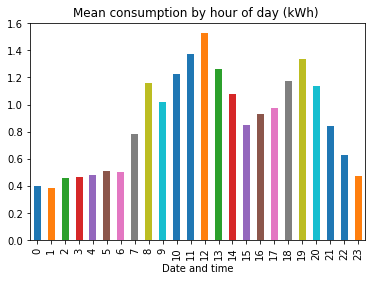

In [3]:
#A look at an average day:
means = data.groupby(data['Date and time'].apply(lambda d : d.hour)).mean()['kWh']
means.plot(kind='bar', title='Mean consumption by hour of day (kWh) ');

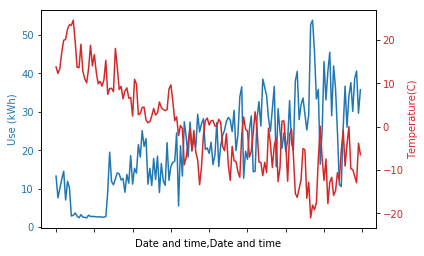

In [4]:
#A look at how the use and temperature evolve over the year: 

fig, ax1 = plt.subplots()
ax1.set_xlabel('Day')
ax1.set_ylabel('Use (kWh)', color='tab:blue')
data.groupby(by=[data['Date and time'].apply(lambda d: d.year), data['Date and time'].apply(lambda d: d.dayofyear)]).sum()['kWh'].plot(ax=ax1, color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Temperature(C)', color='tab:red')  # we already handled the x-label with ax1
data.groupby(by=[data['Date and time'].apply(lambda d: d.year), data['Date and time'].apply(lambda d: d.dayofyear)]).mean()['Average temperature (°C)'].plot(ax=ax2, color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

C:\Users\Simon\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


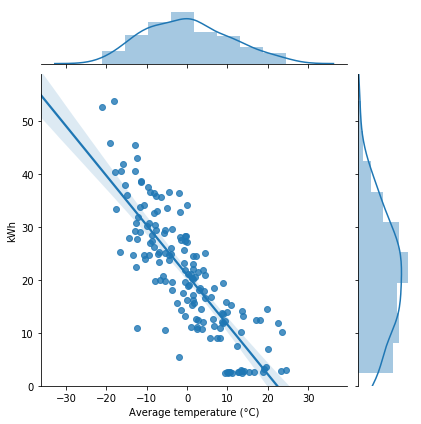

In [5]:
#Investigating the correlation between temperature and electricity consumption
grouped = data.groupby(data['Date and time'].apply(lambda d: d.dayofyear))

daily_temp =grouped.mean()['Average temperature (°C)']
daily_use = grouped.sum()['kWh']

sns.jointplot(x=daily_temp, y=daily_use, kind='reg')
plt.ylim(bottom=0, top = daily_use.max()+5);

In [6]:
#Find a model for use = f(temperature)
from sklearn.linear_model import LinearRegression

X_train = np.array(daily_temp).reshape(-1, 1)
y_train = np.array(daily_use).reshape(-1, 1)

model = LinearRegression()
model.fit(X_train,y_train)    

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

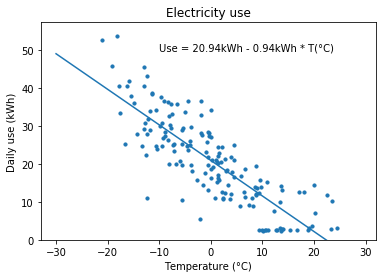

In [7]:
#Plot the use as a function of temperature
def use_temp(tmin, tmax):
    #Plot linear regression line
    plt.plot(range(tmin, tmax), [model.predict(temp)[0][0] for temp in range(tmin,tmax)])
    plt.xlabel('Temperature (°C)')
    plt.ylabel('Daily use (kWh)')
    plt.title('Electricity use')
    
    f1 = "Use = {:.2f}kWh - {:.2f}kWh * T(°C)".format(model.intercept_[0] ,-1*(model.coef_[0][0]))
    plt.annotate(f1, xy=(10,10), xytext=(-10,50))


    #Plot data alongside prediction line
    plt.scatter(x=daily_temp, y=daily_use, marker='o', s=10)
    plt.ylim(bottom=0)
    
use_temp(-30,30)